# IMPORT LIBRARY

In [1]:
!pip install -U scipy

In [2]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from keras.preprocessing.image import ImageDataGenerator


In [4]:
from skimage import img_as_float
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma
from skimage.filters import threshold_multiotsu,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing,disk
from skimage.measure import label, regionprops,find_contours
from skimage.morphology import erosion, dilation, opening, closing,disk
import cv2


In [5]:
from tensorflow.keras.applications import MobileNet,VGG19,EfficientNetV2S
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,BatchNormalization,Input,Conv2D,MaxPooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential


# LOAD DATA

In [6]:
chexpert_train = pd.read_csv('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/train.csv')
chexpert_valid = pd.read_csv('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid.csv')


In [7]:
chexpert_train.shape,chexpert_valid.shape

((223414, 19), (234, 19))

In [8]:
chexpert_train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [9]:
# use only Frontal
chexpert_train = chexpert_train[chexpert_train['Frontal/Lateral'] == "Frontal"]
chexpert_valid = chexpert_valid[chexpert_valid['Frontal/Lateral'] == "Frontal"]

In [10]:
# fill empty value
chexpert_train = chexpert_train.fillna(0)
chexpert_valid = chexpert_valid.fillna(0)

In [11]:
# thay giá trị ko có -1 thành 0
chexpert_train = chexpert_train.replace(-1,0)
chexpert_valid = chexpert_valid.replace(-1,0)

In [12]:
# thêm path để load file
chexpert_train['Path'] = r'../input/chexpert-v10-small/' + chexpert_train['Path']
chexpert_valid['Path'] = r'../input/chexpert-v10-small/' + chexpert_valid['Path']


In [13]:
chexpert_train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,../input/chexpert-v10-small/CheXpert-v1.0-smal...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,../input/chexpert-v10-small/CheXpert-v1.0-smal...,Female,87,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,../input/chexpert-v10-small/CheXpert-v1.0-smal...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,../input/chexpert-v10-small/CheXpert-v1.0-smal...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,../input/chexpert-v10-small/CheXpert-v1.0-smal...,Female,20,Frontal,PA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# DATA PREPROCESSING

In [14]:
all_labels = ["Enlarged Cardiomediastinum", "Cardiomegaly","Lung Opacity",'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

<BarContainer object of 13 artists>

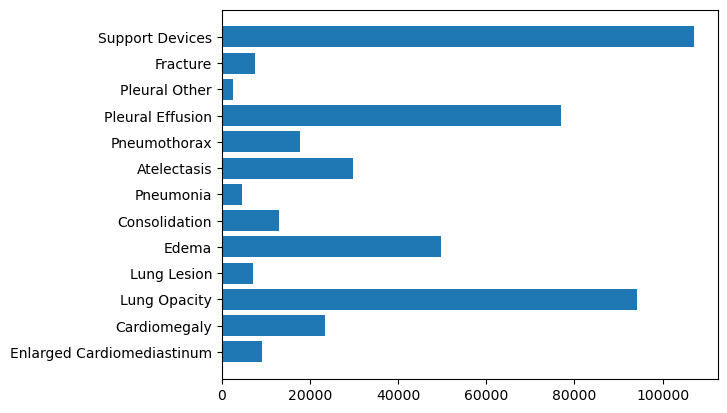

In [15]:
# thông kê nhãn
plt.barh(y = all_labels,width = chexpert_train[all_labels].sum(axis=0).values)

## Train test split

In [16]:
# lấy 40000 mẫu có trọng số
chexpert_train['join_label'] = chexpert_train[all_labels].sum(axis=1) + 4e-2
sample_weights = chexpert_train['join_label']
sample_weights /= sample_weights.sum()
chexpert_train = chexpert_train.sample(40000, weights=sample_weights)


In [17]:
chexpert_train_df, chexpert_valid_df = train_test_split(chexpert_train,
                                               test_size = 0.2,
                                               random_state = 18,
                                              )

# Data Generator

In [18]:
IMAGE_SIZE = 128

In [19]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))


DEVICES AVAILABLE: 1


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE_PER_REPLICA = 32

#We obtain the BATCH_SIZE dividing by the number of devices. 
BATCH_SIZE = BATCH_SIZE_PER_REPLICA*strategy.num_replicas_in_sync


In [21]:
core_idg = ImageDataGenerator()


In [22]:
train_generator = core_idg.flow_from_dataframe(dataframe=chexpert_train_df,
                                        directory=None,
                                        x_col = 'Path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)
valid_generator = core_idg.flow_from_dataframe(dataframe=chexpert_valid_df,
                                        directory=None,
                                        x_col = 'Path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 256)


Found 32000 validated image filenames.
Found 8000 validated image filenames.


In [23]:
raw_train_data = tf.data.Dataset.from_generator(
                lambda: train_generator,
                output_types = (tf.float32, tf.float32), 
                output_shapes = ([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))


raw_valid_data = tf.data.Dataset.from_generator(
                lambda: valid_generator,
                output_types=(tf.float32, tf.float32), 
                output_shapes=([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))


In [45]:
one_batch_samples = next(iter(raw_train_data))


In [46]:
image_samples, label_samples = one_batch_samples


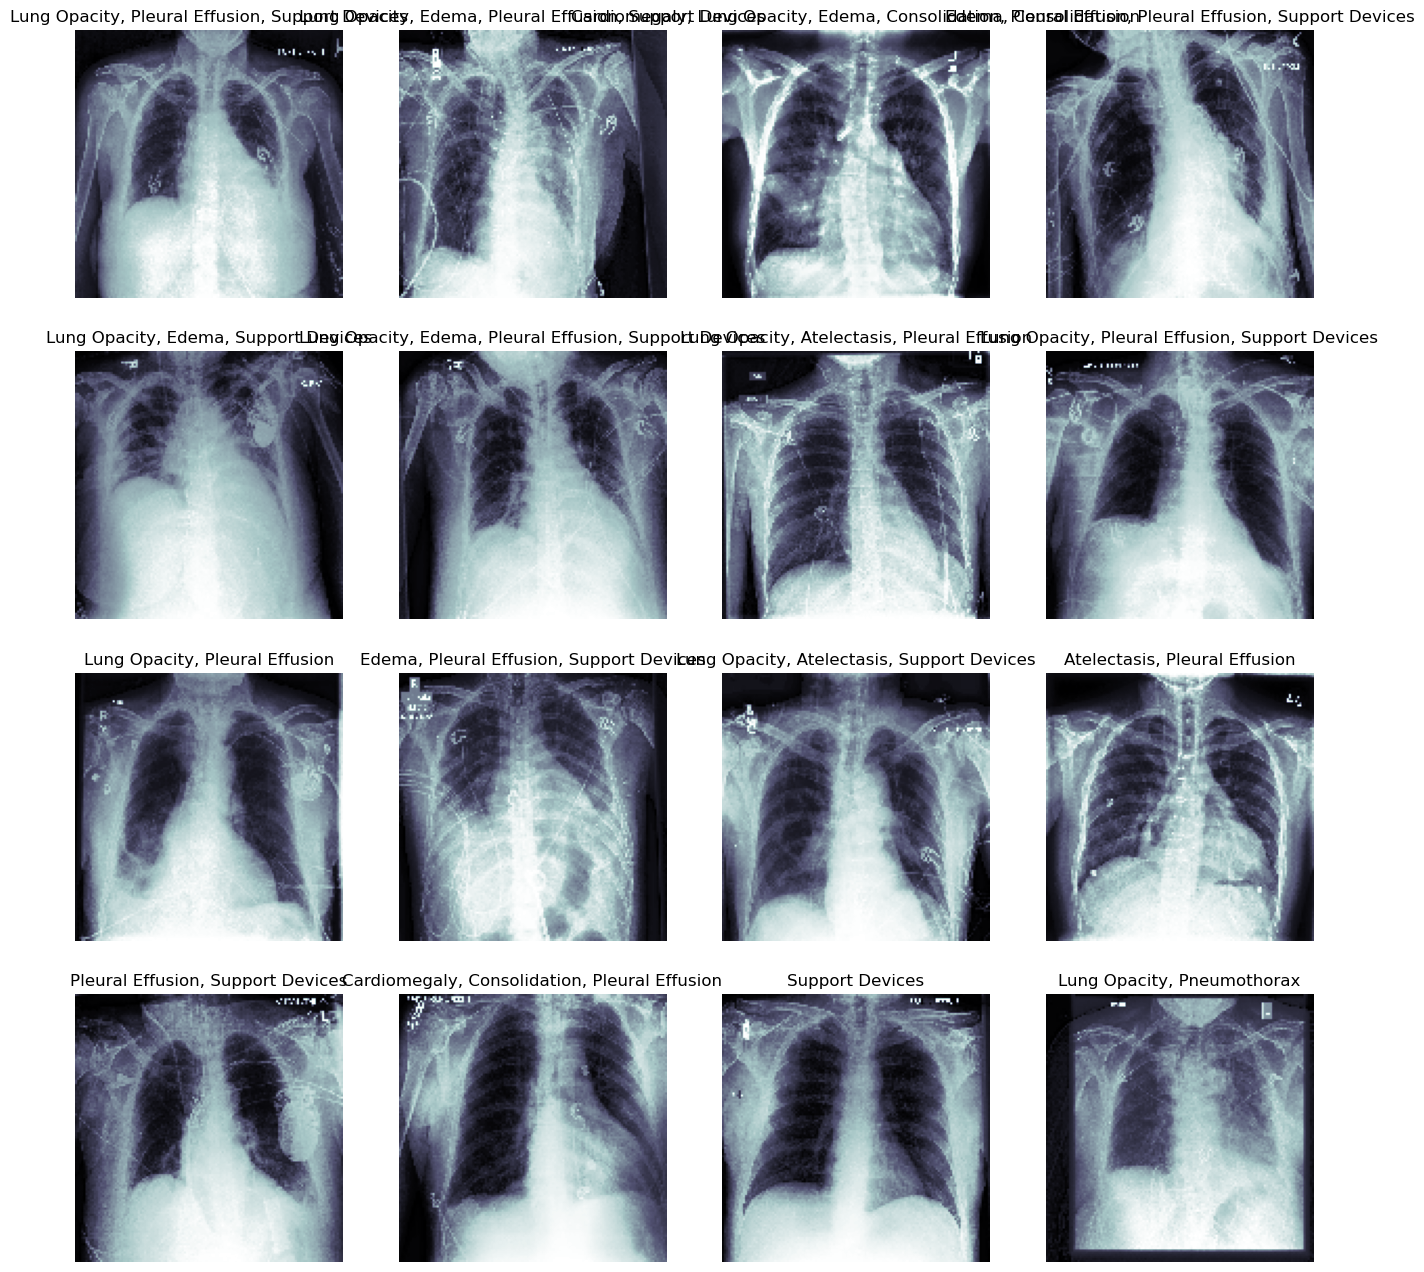

In [47]:
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
for (img, lb, ax) in zip(image_samples, label_samples, axes.flatten()):
    ax.imshow(img, cmap = 'bone')
    img_lab_name = np.array(all_labels)[lb.numpy() == 1.0]
    
    ax.set_title(', '.join(img_lab_name))
    ax.axis('off')


## RESCALE

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [25]:
scale_train_data = raw_train_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)
scale_valid_data = raw_valid_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)


## BACKGROUND REMOVAL

In [26]:
def background_rm(image):
    
    img_list = []
    for i in range(image.shape[0]):
        try:
            img = image[i]

            sumOfCols = np.sum(img, axis=0)
            sumOfRows = np.sum(img, axis=1)

            for j in range(len(sumOfCols)):
                if sumOfCols[j] > 0:
                    x1 = j
                    break

            for j in range(len(sumOfCols)-1,-1,-1):
                if sumOfCols[j] > 0:
                    x2 = j
                    break

            for j in range(len(sumOfRows)):
                if sumOfRows[j] > 0:
                    y1 = j
                    break

            for j in range(len(sumOfRows)-1,-1,-1):
                if sumOfRows[j] > 0:
                    y2 = j
                    break

            roi = img[y1:y2,x1:x2]
            roi = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE) (roi)
            img_list.append(roi)
        except:
            img_list.append(image)

    return tf.convert_to_tensor(tf.stack(img_list))


In [27]:
def background_rm_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(background_rm, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [28]:
rm_background_train_data = scale_train_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)
rm_background_valid_data = scale_valid_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)


## REMOVE NOISE

In [29]:
def denoise(image):
    return denoise_tv_chambolle(img_as_float(image), weight=0.01)

In [30]:
def denoise_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(denoise, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [31]:
rm_noise_train_data = rm_background_train_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)
rm_noise_valid_data = rm_background_valid_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)


## REMOVE THE DIAPHRAGM REGION


In [32]:
def rmDiapgRegion(image):
    img = img_as_float(image)
    img = np.copy(img)
    # get Diaphragm Region
    
    brightest = img.max()
    darkest = img.min()
#     print(brightest)
    T = darkest + 0.94 * (brightest - darkest)
    binary = img > T

    closed = closing(binary) 
    dilate = dilation(closed)

    # get high density region
    l = label(dilate)
    out = (l==np.bincount(l.ravel())[1:].argmax()+1).astype(np.int64)

    # smoothing region
#     opened = closing(out)
    img[out.astype(np.float32) == 1.0] = 0
        
    return img


In [33]:
def rmDiapgRegion_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(rmDiapgRegion, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [34]:
rm_diapg_train_data = rm_noise_train_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)
rm_diapg_valid_data = rm_noise_valid_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)

## CONTRAST ENRICHMENT

In [35]:
def contrast_enrich(image):
    return exposure.equalize_adapthist(img_as_float(image),clip_limit = 0.02)
        

In [36]:
def contrast_enrich_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(contrast_enrich, [image,], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [37]:
enhance_contrast_train_data = rm_diapg_train_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)
enhance_contrast_valid_data = rm_diapg_valid_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)


# MODEL

In [38]:
train_data = enhance_contrast_train_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)
valid_data = enhance_contrast_valid_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)

In [39]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=chexpert_valid_df,
                                        directory=None,
                                        x_col = 'Path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 1024))


Found 8000 validated image filenames.


In [40]:
test_X_normal = tf.keras.layers.Rescaling(1./255) (test_X)
test_X_normal = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_normal))

In [41]:
test_X_process = test_X.copy()

test_X_process = background_rm(test_X_process)
test_X_process = tf.keras.layers.Rescaling(1./255) (test_X_process)
test_X_process = denoise(test_X_process)
test_X_process = rmDiapgRegion(test_X_process)
test_X_process = contrast_enrich(test_X_process)
test_X_process = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_process))

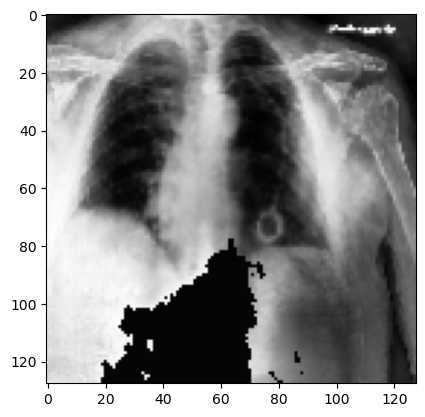

In [71]:
plt.imshow(test_X_process[4],cmap = 'bone')

## DENSE121

In [62]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

dense121 = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",pooling='avg')
dense121 = dense121(input,)

output = Dense(len(all_labels), activation = 'sigmoid') (dense121)

dense121_model = tf.keras.Model(inputs=[input], outputs=[output])
dense121_model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_1 (Dense)             (None, 13)                13325     
                                                                 
Total params: 7,050,829
Trainable params: 6,967,181
Non-trainable params: 83,648
_________________________________________________________________


In [63]:
dense121_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [64]:
steps_per_epoch = chexpert_train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

1000

In [65]:
# dense121_model.load_weights("/kaggle/input/chexpert-weights/dense121_chexpert_process_2.h5")

In [66]:
# dense121_model.fit(train_data, 
#             steps_per_epoch = 750,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

In [67]:
# dense121_model.save_weights("dense121_chexpert_process_3.h5")

### NORMAL

In [68]:
dense121_model.load_weights("/kaggle/input/weights-2/dense121_chexpert_normal_3.h5")

In [69]:
y_pred_dense121_normal = dense121_model.predict(test_X_normal)
y_pred_dense121_normal[:5]


32/32 [==============================] - 5s 25ms/step


array([[0.03576503, 0.16369829, 0.60075134, 0.06708965, 0.16801395,
        0.22504477, 0.02674664, 0.22952455, 0.00783936, 0.92561364,
        0.00863304, 0.01985967, 0.49660158],
       [0.0709924 , 0.06893827, 0.5208239 , 0.03159018, 0.08588145,
        0.05844823, 0.01403558, 0.24869053, 0.5419957 , 0.75565296,
        0.02855315, 0.050423  , 0.6108862 ],
       [0.03390807, 0.49203798, 0.62218654, 0.02844143, 0.7059409 ,
        0.10667499, 0.077632  , 0.07865328, 0.01708403, 0.09159339,
        0.00646641, 0.0426947 , 0.28698352],
       [0.01293362, 0.10611825, 0.73918307, 0.0454946 , 0.57941985,
        0.17781328, 0.06418596, 0.22420192, 0.03354669, 0.94095844,
        0.00779806, 0.02401031, 0.48869932],
       [0.084385  , 0.12445977, 0.6883336 , 0.1068446 , 0.17846201,
        0.12361777, 0.04662414, 0.06600775, 0.5269195 , 0.57688373,
        0.1059413 , 0.04622242, 0.78643996]], dtype=float32)

0.651631335810052


Text(0, 0.5, 'True Positive Rate')

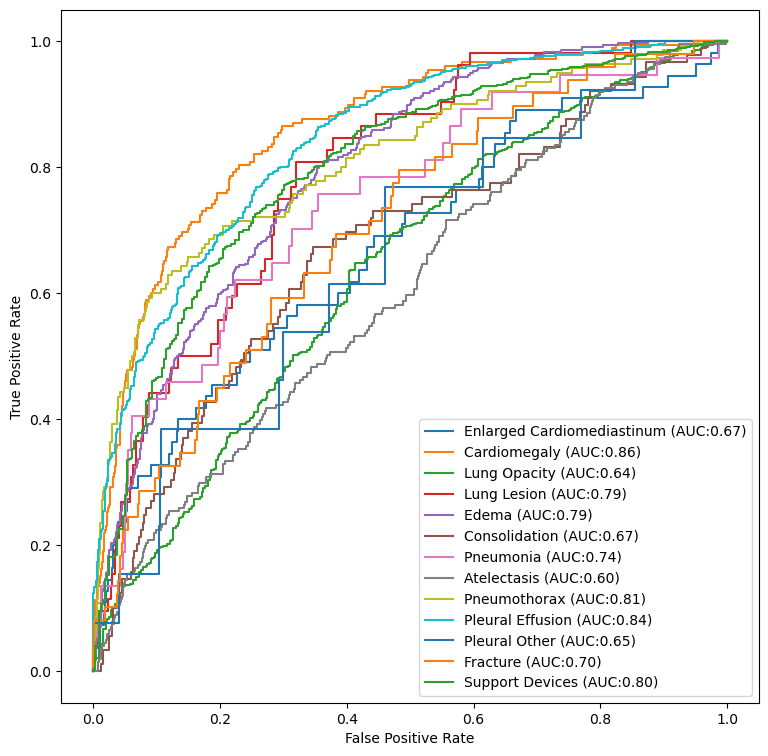

In [74]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_dense121_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_dense121_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_dense121_normal += auc(fpr, tpr)

mean_auc_dense121_normal /= 14
print(mean_auc_dense121_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


### PREPROCESS

In [78]:
dense121_model.load_weights("/kaggle/input/chexpert-weights/dense121_chexpert_process_1.h5")

In [79]:
y_pred_dense121_process = dense121_model.predict(test_X_process)
y_pred_dense121_process[:5]


32/32 [==============================] - 1s 24ms/step


array([[0.0901735 , 0.09685519, 0.57748973, 0.11269674, 0.24335888,
        0.14045139, 0.04772266, 0.26084825, 0.06701571, 0.33504683,
        0.03563586, 0.09832934, 0.55612   ],
       [0.05709781, 0.15788382, 0.6941703 , 0.04770938, 0.11421767,
        0.19594136, 0.06196058, 0.3195066 , 0.19227989, 0.5790389 ,
        0.02249382, 0.05405501, 0.54467475],
       [0.05073853, 0.20655142, 0.6076141 , 0.05186583, 0.37719962,
        0.10763925, 0.06012837, 0.21472332, 0.04670927, 0.15526734,
        0.02549077, 0.17350991, 0.6631136 ],
       [0.01891327, 0.23716313, 0.7766254 , 0.01467805, 0.2767404 ,
        0.30286774, 0.04500451, 0.21703573, 0.10399756, 0.7392402 ,
        0.01099784, 0.0333709 , 0.73380375],
       [0.03647143, 0.09186883, 0.82009065, 0.06153225, 0.12538804,
        0.19920431, 0.0584214 , 0.19400032, 0.3998874 , 0.3639466 ,
        0.03604931, 0.05998944, 0.32836598]], dtype=float32)

0.6098339487868593


Text(0, 0.5, 'True Positive Rate')

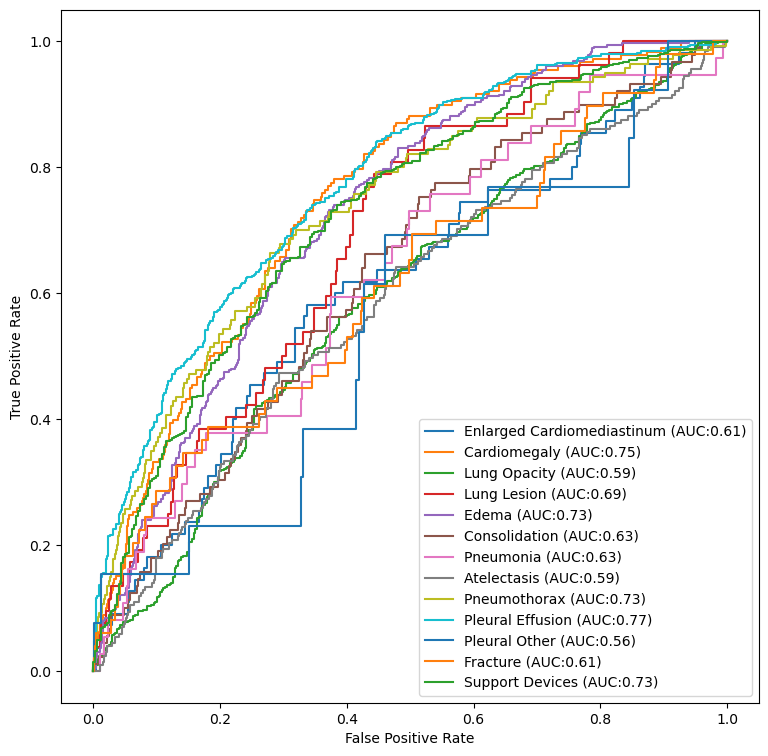

In [83]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_dense121_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_dense121_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_dense121_process += auc(fpr, tpr)

mean_auc_dense121_process /= 14
print(mean_auc_dense121_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


## VGG19

In [42]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)
processed_input = tf.keras.applications.vgg19.preprocess_input(input)

vgg19 = VGG19(include_top = False,weights = 'imagenet') 
vgg19 = vgg19(input)

normal = BatchNormalization() (vgg19)
flatten = GlobalAveragePooling2D() (normal)

output = Dense(len(all_labels), activation = 'sigmoid') (flatten)

vgg19_model = tf.keras.Model(inputs=[input], outputs=[output])
vgg19_model.summary()


80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 13)                6669      
                                                              

In [43]:
# vgg19_model.load_weights("/kaggle/input/chexpert-weights/vgg19_chexpert_process_2.h5")


In [ ]:
vgg19_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [ ]:
steps_per_epoch = chexpert_train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

In [ ]:
vgg19_model.fit(train_data, 
            steps_per_epoch = steps_per_epoch,
#           validation_data = valid_data, 
            epochs = 1, 
            verbose = 1,
          )


In [ ]:
vgg19_model.save_weights("vgg19_chexpert_process_3.h5")


### NORMAL

In [53]:
vgg19_model.load_weights("/kaggle/input/weights-2/vgg19_chexpert_normal_1.h5")

In [54]:
y_pred_vgg19_normal = vgg19_model.predict(test_X_normal)
y_pred_vgg19_normal[:5]


32/32 [==============================] - 1s 24ms/step


array([[0.0450316 , 0.11340797, 0.6844243 , 0.05087926, 0.22458701,
        0.07917395, 0.03625806, 0.4071807 , 0.1286305 , 0.8900873 ,
        0.04168214, 0.03814766, 0.41189992],
       [0.03564471, 0.00300344, 0.58921486, 0.14543992, 0.11680306,
        0.04683834, 0.04813664, 0.5274419 , 0.8418104 , 0.69188964,
        0.12597343, 0.09803762, 0.25678277],
       [0.05422505, 0.05525746, 0.5860704 , 0.12778416, 0.33804923,
        0.06083489, 0.06002475, 0.28346312, 0.5636402 , 0.3808379 ,
        0.13605265, 0.08776146, 0.28272054],
       [0.02979815, 0.05224897, 0.7363296 , 0.05095689, 0.522809  ,
        0.09848492, 0.03725515, 0.4366957 , 0.26251155, 0.9689143 ,
        0.04212504, 0.03494457, 0.37439042],
       [0.05631392, 0.02750762, 0.62442255, 0.14832596, 0.34871352,
        0.09177615, 0.06896975, 0.30460548, 0.7561441 , 0.64374655,
        0.15616821, 0.08916001, 0.30050823]], dtype=float32)

0.6358441966594285


Text(0, 0.5, 'True Positive Rate')

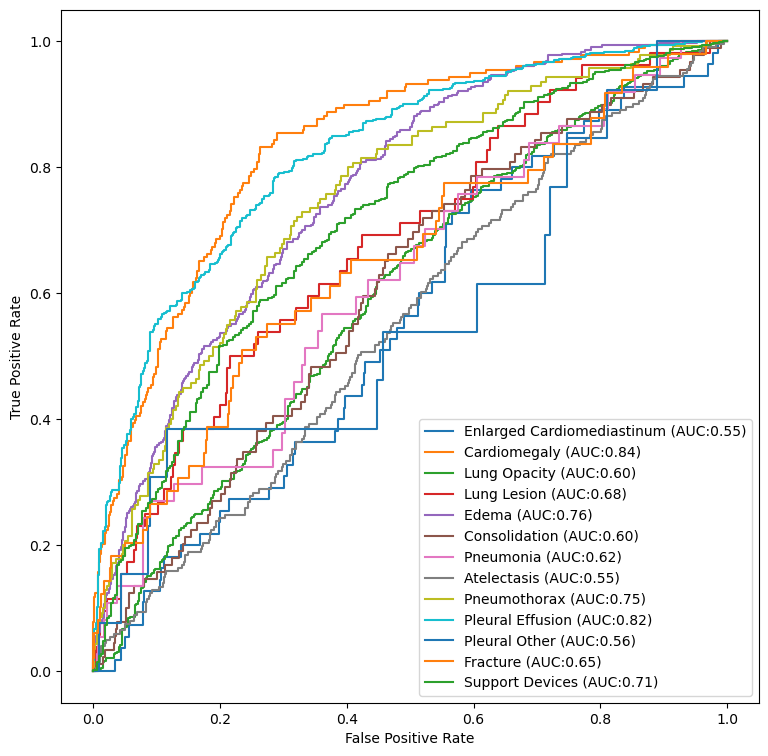

In [59]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_normal += auc(fpr, tpr)
mean_auc_vgg19_normal /= 14
print(mean_auc_vgg19_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS 

In [84]:
vgg19_model.load_weights("/kaggle/input/chexpert-weights/vgg19_chexpert_process_3.h5")


In [85]:
y_pred_vgg19_process = vgg19_model.predict(test_X_process)
y_pred_vgg19_process[:5]


32/32 [==============================] - 1s 24ms/step


array([[0.06538238, 0.09995941, 0.44674522, 0.08701019, 0.10665724,
        0.06414031, 0.0428688 , 0.23807822, 0.14238125, 0.2271384 ,
        0.03892243, 0.08967616, 0.45025548],
       [0.06372654, 0.05374406, 0.38700196, 0.11458901, 0.05909672,
        0.05049306, 0.04228332, 0.28418   , 0.1855194 , 0.13878725,
        0.04774224, 0.12746443, 0.4134995 ],
       [0.06535362, 0.08415961, 0.42138737, 0.07638477, 0.1040932 ,
        0.04820836, 0.03393582, 0.2585871 , 0.13617012, 0.16010821,
        0.03161101, 0.09851943, 0.4962031 ],
       [0.06607292, 0.14465016, 0.50456524, 0.07496877, 0.14538665,
        0.07090307, 0.03969254, 0.1921643 , 0.13214576, 0.39031085,
        0.03690976, 0.06250612, 0.4317862 ],
       [0.08850624, 0.0772789 , 0.41182077, 0.14932002, 0.05163201,
        0.06856407, 0.05127292, 0.20816027, 0.26660836, 0.18636066,
        0.08216605, 0.14131813, 0.4419778 ]], dtype=float32)

0.6068342415999417


Text(0, 0.5, 'True Positive Rate')

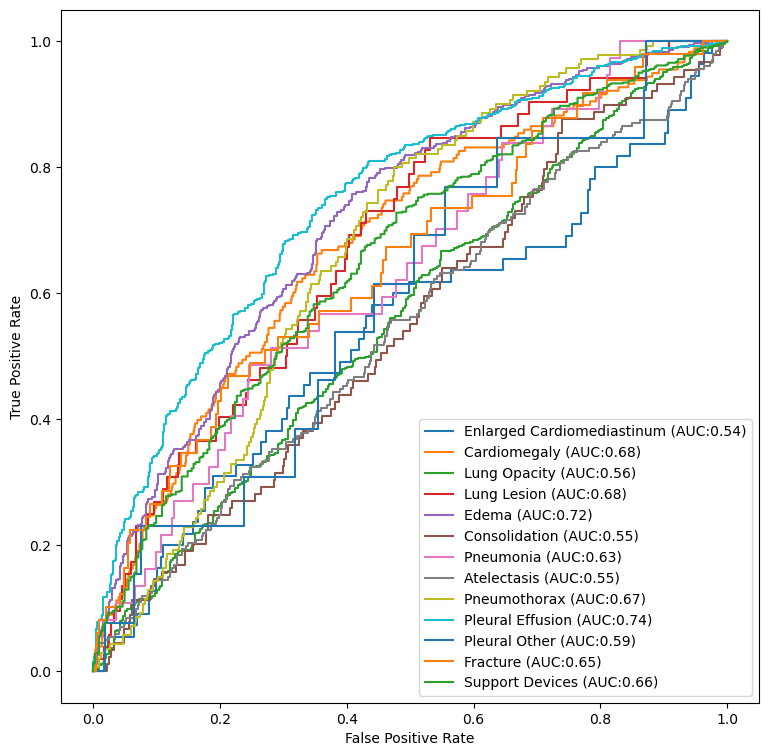

In [90]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)+))
    mean_auc_vgg19_process += auc(fpr, tpr)

mean_auc_vgg19_process /= 14
print(mean_auc_vgg19_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

## EfficientNetV2S 

In [91]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

eff = tf.keras.applications.EfficientNetV2S(include_top = False,weights = 'imagenet') 
eff = eff(input)

normal = BatchNormalization() (eff)
flatten = GlobalAveragePooling2D() (normal)

output = Dense(len(all_labels), activation = 'sigmoid') (flatten)

eff_model = tf.keras.Model(inputs=[input], outputs=[output])
eff_model.summary()

82420632/82420632 [==============================] - 4s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 1280)       5120      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 13)                16653

In [ ]:
eff_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [ ]:
steps_per_epoch = chexpert_train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

In [ ]:
eff_model.load_weights("/kaggle/input/chexpert-weights/eff_chexpert_process_2.h5")


In [ ]:
eff_model.fit(train_data, 
            steps_per_epoch = steps_per_epoch,
#           validation_data = valid_data, 
            epochs = 1, 
            verbose = 1,
          )


In [ ]:
eff_model.save_weights("eff_chexpert_process_3.h5")


### NORMAL

In [95]:
eff_model.load_weights("/kaggle/input/weights-2/eff_chexpert_normal_2.h5")

In [96]:
y_pred_eff_normal = eff_model.predict(test_X_normal)
y_pred_eff_normal[:5]


32/32 [==============================] - 1s 32ms/step


array([[0.08704725, 0.2201979 , 0.6093619 , 0.20311698, 0.17344435,
        0.24413005, 0.04161217, 0.2682343 , 0.04704903, 0.9661474 ,
        0.01615352, 0.02677393, 0.3290593 ],
       [0.06214524, 0.01339224, 0.556936  , 0.0504966 , 0.07199142,
        0.05582792, 0.01491693, 0.2563275 , 0.6462679 , 0.70972544,
        0.01220997, 0.02861155, 0.55091834],
       [0.03356501, 0.24451992, 0.65896606, 0.04731219, 0.5523802 ,
        0.08518385, 0.07934695, 0.10709813, 0.0597102 , 0.10392995,
        0.02121797, 0.02648476, 0.36224735],
       [0.0292007 , 0.04243094, 0.6216348 , 0.07548941, 0.32158488,
        0.15729691, 0.03127278, 0.2005059 , 0.15078403, 0.97943795,
        0.00633044, 0.01294898, 0.49128127],
       [0.06858353, 0.03163658, 0.62188673, 0.08189626, 0.10017718,
        0.05269641, 0.01752568, 0.13619082, 0.72479016, 0.46527764,
        0.02728135, 0.03997109, 0.74845016]], dtype=float32)

0.664524074966784


Text(0, 0.5, 'True Positive Rate')

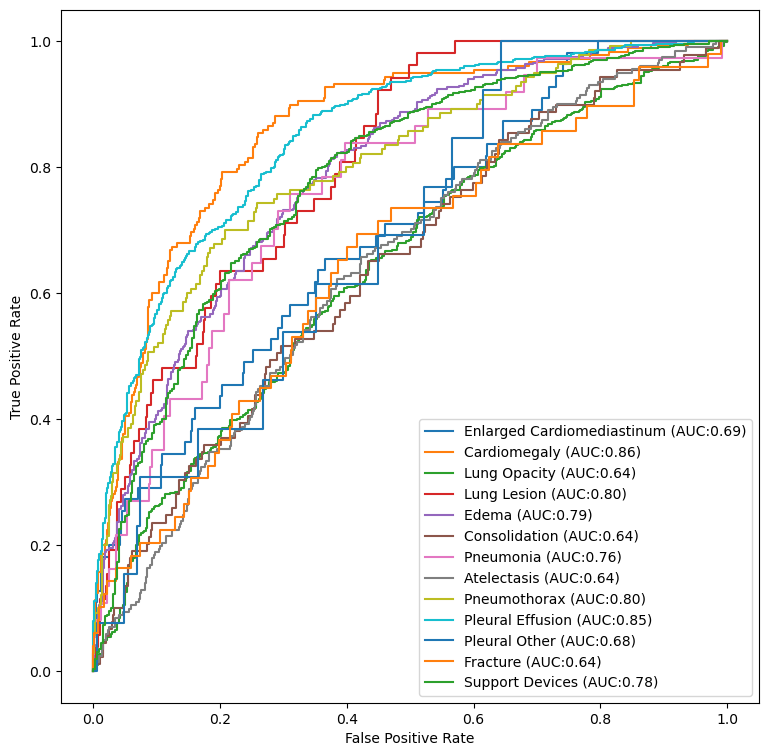

In [99]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_eff_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_eff_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_eff_normal += auc(fpr, tpr)

mean_auc_eff_normal /=14

print(mean_auc_eff_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS

In [100]:
eff_model.load_weights("/kaggle/input/chexpert-weights/eff_chexpert_process_3.h5")

In [101]:
y_pred_eff_process = eff_model.predict(test_X_process)
y_pred_eff_process[:5]


32/32 [==============================] - 1s 30ms/step


array([[0.10181253, 0.32429537, 0.62446797, 0.13877884, 0.20728046,
        0.16814764, 0.05085956, 0.15427932, 0.13507572, 0.76968104,
        0.04149268, 0.04459974, 0.46719074],
       [0.09157541, 0.07518709, 0.6346024 , 0.07483193, 0.07067211,
        0.09140083, 0.02534989, 0.17404895, 0.6638219 , 0.55969656,
        0.07692855, 0.03621741, 0.7222468 ],
       [0.03920238, 0.82201594, 0.42645732, 0.02970739, 0.6844847 ,
        0.03479216, 0.03100358, 0.10725442, 0.015159  , 0.11365931,
        0.00475226, 0.02291448, 0.48825628],
       [0.03634517, 0.13766026, 0.7083493 , 0.03977595, 0.6432301 ,
        0.19574037, 0.04060642, 0.15639219, 0.03714614, 0.9197548 ,
        0.00662065, 0.01832777, 0.4251033 ],
       [0.12909082, 0.21449058, 0.6878855 , 0.11470356, 0.26110655,
        0.06818052, 0.03777296, 0.11347733, 0.37168843, 0.594723  ,
        0.07129633, 0.0624183 , 0.59697986]], dtype=float32)

0.6864360525763585


Text(0, 0.5, 'True Positive Rate')

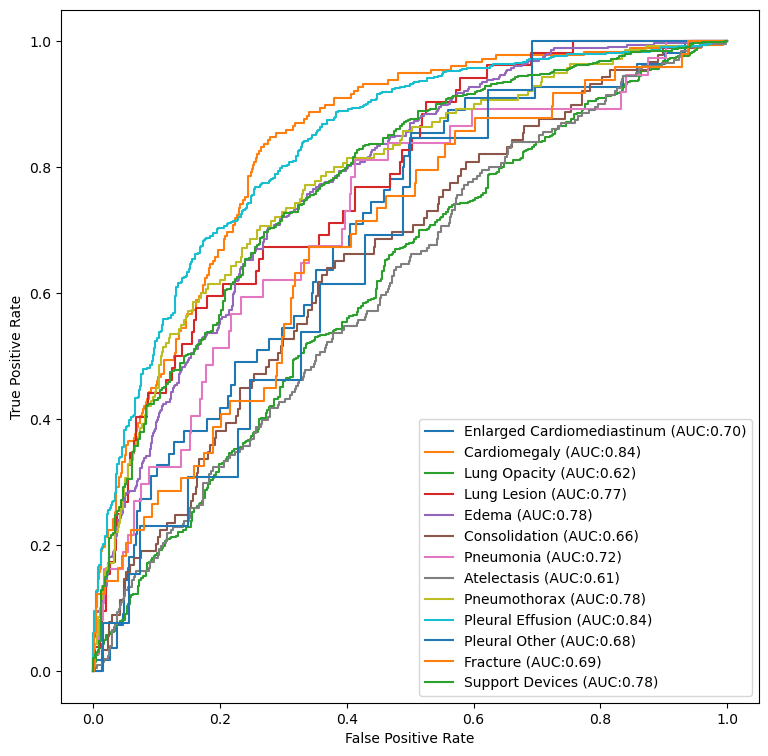

In [107]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_eff_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_eff_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_eff_process += auc(fpr, tpr)
    
mean_auc_eff_process /=14
print(mean_auc_eff_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

## ConvNet

In [108]:
import tensorflow_hub as hub

In [109]:
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_base_21k_1k_224_fe/1"

In [110]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32, name = 'input')
input_conv = tf.keras.layers.Resizing(224,224, name = 'resize_input') (input)

hub_layer = hub.KerasLayer(MODEL_PATH, trainable=True, name = "ConvNet")
conv_model = hub_layer (input_conv)

dense1 = Dense(768, activation = tf.keras.activations.gelu, name = "dense_768") (conv_model)
dense1 = Dense(512, activation = tf.keras.activations.gelu, name = "dense_512") (dense1)
dense1 = Dense(128, activation = tf.keras.activations.gelu, name = "dense_128") (dense1)
output = Dense(len(all_labels), activation = 'sigmoid',name = 'output') (dense1)

conv_model = tf.keras.Model(inputs=[input], outputs=[output])
conv_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 resize_input (Resizing)     (None, 224, 224, 3)       0         
                                                                 
 ConvNet (KerasLayer)        (None, 1024)              87566464  
                                                                 
 dense_768 (Dense)           (None, 768)               787200    
                                                                 
 dense_512 (Dense)           (None, 512)               393728    
                                                                 
 dense_128 (Dense)           (None, 128)               65664     
                                                                 
 output (Dense)              (None, 13)                1677

In [ ]:
conv_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(3e-5), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [ ]:
steps_per_epoch = chexpert_train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

In [ ]:
# conv_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

### NORMAL

In [120]:
conv_model.load_weights('/kaggle/input/weights-2/conv_2/my_checkpoint')

In [121]:
y_pred_conv_normal = conv_model.predict(test_X_normal)
y_pred_conv_normal[:5]


32/32 [==============================] - 9s 294ms/step


array([[0.04407246, 0.08093026, 0.760837  , 0.15015258, 0.10882455,
        0.26424557, 0.04686072, 0.17018852, 0.0598503 , 0.8908732 ,
        0.01478239, 0.03722401, 0.54975915],
       [0.0483433 , 0.01547739, 0.65186745, 0.04287277, 0.04003286,
        0.10749239, 0.01000358, 0.25036296, 0.6283306 , 0.7169117 ,
        0.02988586, 0.03931623, 0.819501  ],
       [0.03697241, 0.32173678, 0.46828476, 0.0358319 , 0.37801358,
        0.08496398, 0.05576428, 0.08087457, 0.04625956, 0.0977135 ,
        0.02054825, 0.02346042, 0.6960136 ],
       [0.03574249, 0.1291254 , 0.7036746 , 0.03855095, 0.50114363,
        0.11605407, 0.02800683, 0.16350839, 0.05904826, 0.9498733 ,
        0.00617982, 0.01754413, 0.37864926],
       [0.05714786, 0.05256132, 0.7528402 , 0.07312095, 0.12132142,
        0.1286767 , 0.0258172 , 0.0370678 , 0.7834737 , 0.50849754,
        0.08857051, 0.02856815, 0.8377459 ]], dtype=float32)

0.6821007800418817


Text(0, 0.5, 'True Positive Rate')

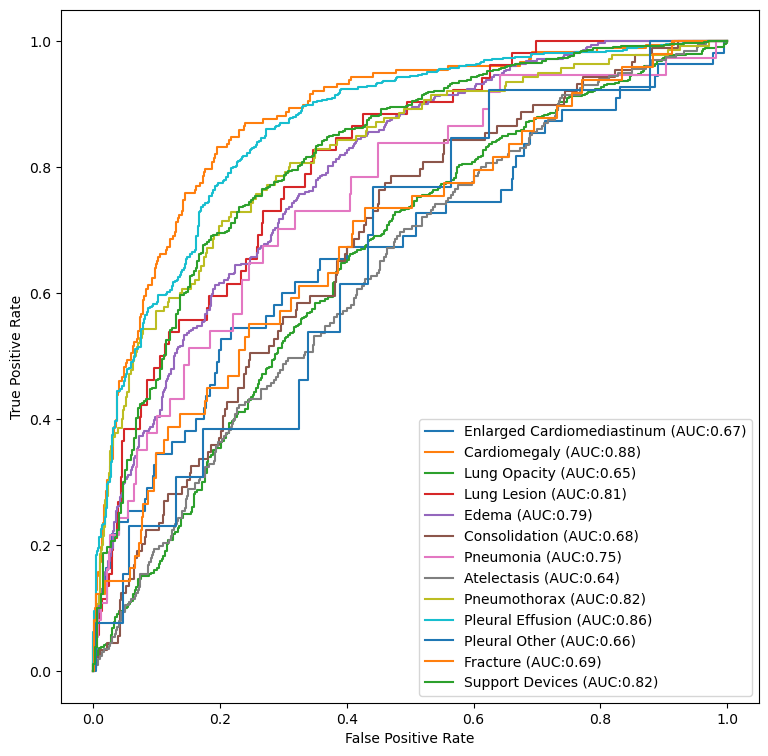

In [125]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_conv_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_conv_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr))
    mean_auc_conv_normal += auc(fpr, tpr)

mean_auc_conv_normal /= 14
print(mean_auc_conv_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS

In [132]:
conv_model.load_weights('/kaggle/input/conv-preproccessing/conv_pre_3/my_checkpoint')


In [133]:
y_pred_conv_process = conv_model.predict(test_X_process)
y_pred_conv_process[:5]


32/32 [==============================] - 9s 294ms/step


array([[0.06477787, 0.23589534, 0.7292959 , 0.18997926, 0.22001559,
        0.19429386, 0.079671  , 0.14836049, 0.03884988, 0.718119  ,
        0.00921648, 0.0196327 , 0.20743015],
       [0.05513263, 0.04430783, 0.5421153 , 0.06226029, 0.03706376,
        0.06878987, 0.01736633, 0.3059655 , 0.6054232 , 0.63761187,
        0.03410074, 0.01746739, 0.6271232 ],
       [0.03737532, 0.57021886, 0.5390121 , 0.05651559, 0.55241454,
        0.05308011, 0.12279978, 0.05257071, 0.04046151, 0.07898074,
        0.01538401, 0.02580647, 0.57533914],
       [0.0265721 , 0.14021145, 0.6796854 , 0.08418229, 0.65226173,
        0.16071524, 0.06494121, 0.16905098, 0.04321849, 0.9558323 ,
        0.00466088, 0.02320908, 0.23838806],
       [0.06018529, 0.08920872, 0.73532325, 0.06310963, 0.1391401 ,
        0.07720993, 0.02168486, 0.10476767, 0.5832677 , 0.69266546,
        0.08077344, 0.03392088, 0.7293046 ]], dtype=float32)

0.7383927145153727


Text(0.5, 1.0, 'AUC for each class')

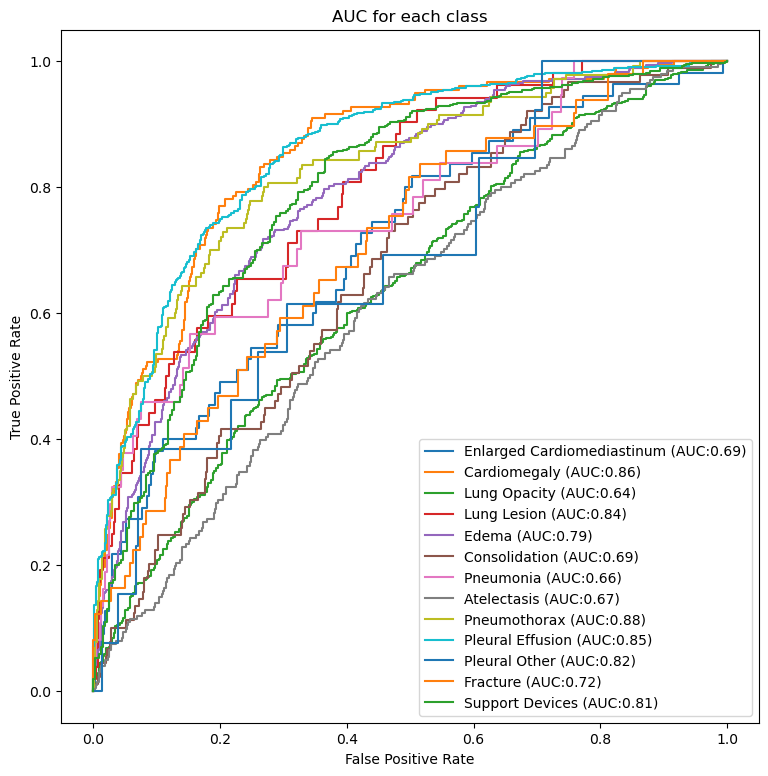

In [144]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_conv_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_conv_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_conv_process += auc(fpr, tpr)

mean_auc_conv_process /= 14
print(mean_auc_conv_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title("AUC for each class")